### Import Libraries and Set the intial variables

In [ ]:
! python3 -m pip install transformers

In [ ]:
! python3 -m pip install torch==1.13.1

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

/home/anhnmt2/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load the data

In [3]:
df = pd.read_csv('../dataset/dataset_capec_combine.csv')
df['text'] = df['text'].str.replace('/',' ')

df = df.sample(frac = 1)
df = df[:10000]

df.shape

(10000, 3)

In [4]:
# Let's have a look at the data 
df.head()

,text,label,category
553256,GET blog wp-login.php,000 - Normal,Normal
136232,GET blog index.php%22+OR+%221%22%3D%221%22+--...,66 - SQL Injection,Injection
144577,GET blog+AND+1%3D1+--+ index.php et-vel-qui-e...,66 - SQL Injection,Injection
302812,GET blog index.php tag https%3A%2F%2F85017792...,000 - Normal,Normal
536271,GET blog index.php 2020 04 04 rerum-soluta-et...,000 - Normal,Normal


In [5]:
df['label'].unique()

array(['000 - Normal', '66 - SQL Injection',
       '194 - Fake the Source of Data', '126 - Path Traversal',
       '34 - HTTP Response Splitting', '242 - Code Injection',
       '274 - HTTP Verb Tampering', '272 - Protocol Manipulation',
       '310 - Scanning for Vulnerable Software'], dtype=object)

In [6]:
number_labels_dict = {                                                   
          '000 - Normal': 0,
          '66 - SQL Injection': 1,
          '194 - Fake the Source of Data': 2,
          '126 - Path Traversal': 3,
          '34 - HTTP Response Splitting': 4,
          '242 - Code Injection': 5,
          '274 - HTTP Verb Tampering': 6,     
          '272 - Protocol Manipulation': 7, 
          '310 - Scanning for Vulnerable Software': 8                                            
        }

# Function to convert score to request
def to_number(label):
   
    return number_labels_dict[label]

# Apply to the dataset 
df['request'] = df.label.apply(to_number)

In [7]:
class_names = [d for d in number_labels_dict.keys()]
class_names

['000 - Normal',
 '66 - SQL Injection',
 '194 - Fake the Source of Data',
 '126 - Path Traversal',
 '34 - HTTP Response Splitting',
 '242 - Code Injection',
 '274 - HTTP Verb Tampering',
 '272 - Protocol Manipulation',
 '310 - Scanning for Vulnerable Software']

## Data Preprocessing   

The tokenizer will break the sentence into words and give numerical values to each word. 

In [8]:
from transformers import AutoTokenizer, AutoModel

# Build a BERT based tokenizer
tokenizer = AutoTokenizer.from_pretrained("jackaduma/SecBERT")

In [9]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

[SEP] 3
[CLS] 2
[PAD] 0
[UNK] 1


BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review.

In [10]:
# Store length of each review 
token_lens = []

# Iterate through the content slide
for txt in df.text:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

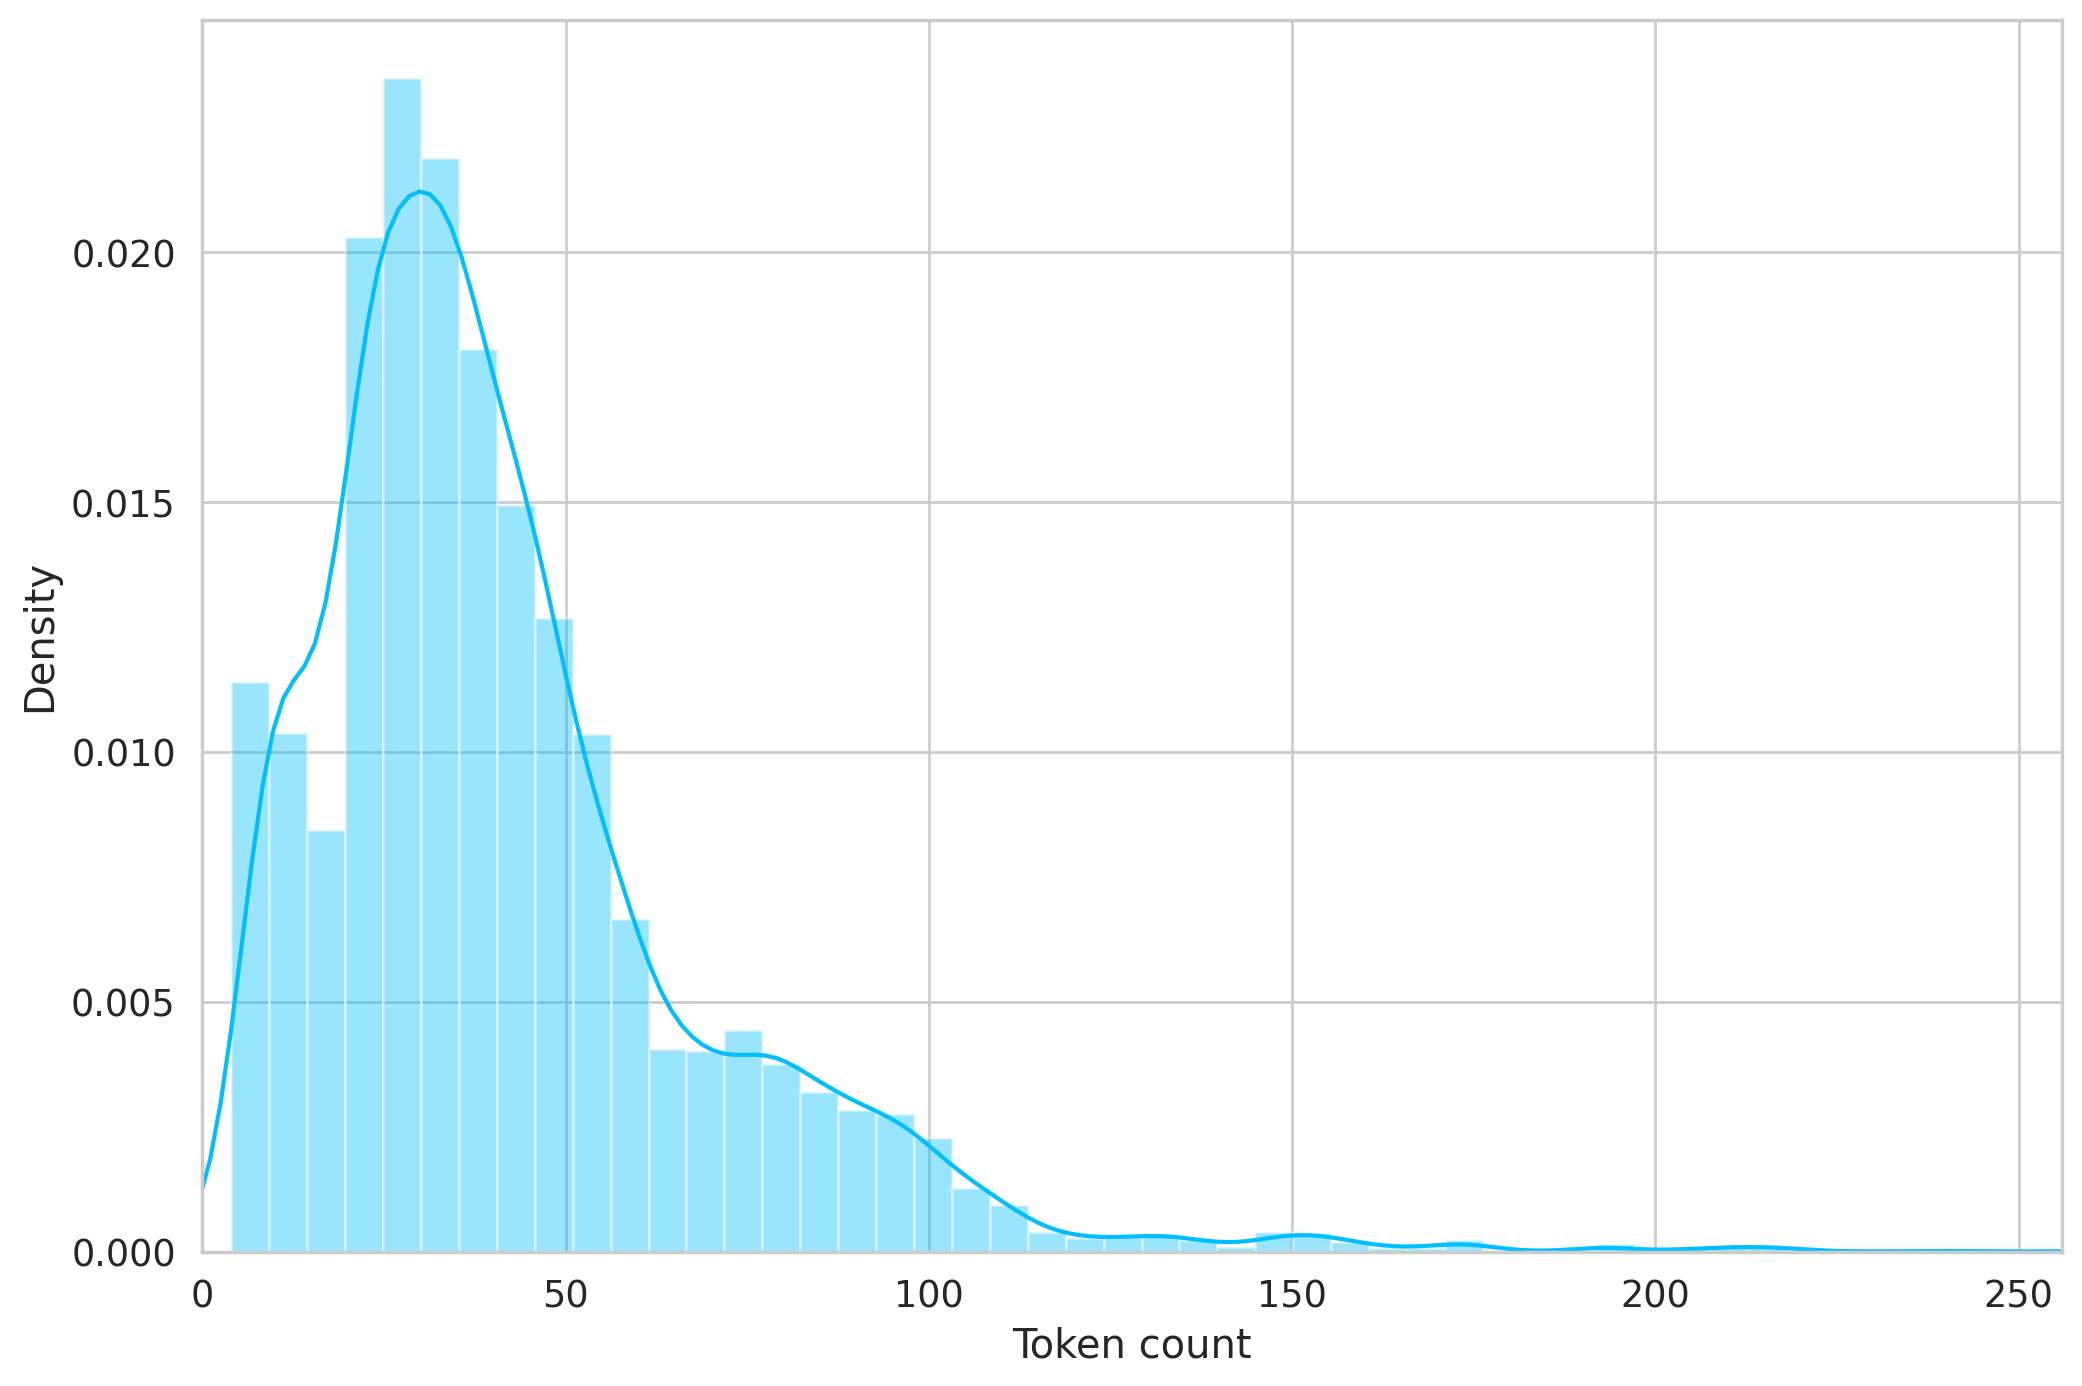

In [11]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 256])
plt.xlabel('Token count')

Most of the reviews seem to contain less than 150 tokens, but we’ll be on the safe side and choose a maximum length of 200. 

In [13]:
MAX_LEN = 200

### Preparing Torch Dataset

To enter data into a PyTorch, we need a more robust data generator class. We will return the review text as well to validate our predictions easily. 

In [14]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        if "num_truncated_tokens" in encoding and encoding["num_truncated_tokens"] > 0:
            # print("Attention! you are cropping tokens")
            pass

        input_ids = encoding["input_ids"]
        attention_mask = encoding["attention_mask"] if "attention_mask" in encoding else None

        token_type_ids = encoding["token_type_ids"] if "token_type_ids" in encoding else None
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

Create a 80% train data and 10% test and 10% validation data

In [15]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(8000, 4) (1000, 4) (1000, 4)


Create a dataloader to release data in batches.

In [16]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.text.to_numpy(),
        targets=df.request.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [17]:
# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [18]:
# Examples 
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 200])
torch.Size([16, 200])
torch.Size([16])


In [19]:
# Load the basic BERT model 
bert_model = AutoModel.from_pretrained('jackaduma/SecBERT')

In [20]:
# Build the request Classifier class 
class requestClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(requestClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained('jackaduma/SecBERT')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        tmp_outputs = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        #  Add a dropout layer 
        pooled_output = tmp_outputs.pooler_output

        output = self.drop(pooled_output)
        return self.out(output)

We use a dropout layer for some regularization and a fully-connected layer for our output. We are returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work. Create an instance and move it to the GPU

In [21]:
# Instantiate the model and move to classifier
model = requestClassifier(len(class_names))
model = model.to(device)

#### Model Characterstics

In [22]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


### Training Phase

we’ll use the AdamW optimizer provided by Hugging Face. It corrects weight decay. We’ll also use a linear scheduler with no warmup

In [23]:
# Number of iterations 
EPOCHS = 1

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [24]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

Write a function to evaluate model performance

In [25]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

Write the training Loop and store the best training state.

In [26]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'model_weight/best_model_state.bin')
        torch.save(model, 'model_weight/best_model.pt')
        best_accuracy = val_acc

Epoch 1/1
----------
Train loss 0.28302369467075916 accuracy 0.9227500000000001
Val   loss 0.1730299854710225 accuracy 0.9500000000000001

CPU times: user 1min 1s, sys: 552 ms, total: 1min 1s
Wall time: 1min 2s


The above took a lot of time but it's finally working. Now, we can plot the training and validation accuracy.

In [30]:
# # Plot training and validation accuracy
# plt.plot(history['train_acc'], label='train accuracy')
# plt.plot(history['val_acc'], label='validation accuracy')

# # Graph chars
# plt.title('Training history')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend()
# plt.ylim([0, 1]);

### Model Evaluation

In [31]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.963

Define a helper function to get predictions from our models. This is similar to the evaluation function, except that we’re storing the text of the reviews and the predicted probabilities

In [32]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [33]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [34]:
print(classification_report(y_test, y_pred, target_names=class_names))

                                        precision    recall  f1-score   support

                          000 - Normal       0.93      0.98      0.95       380
                    66 - SQL Injection       0.99      0.96      0.97       421
         194 - Fake the Source of Data       1.00      0.94      0.97        94
                  126 - Path Traversal       1.00      1.00      1.00        26
          34 - HTTP Response Splitting       1.00      1.00      1.00        35
                  242 - Code Injection       1.00      0.96      0.98        23
             274 - HTTP Verb Tampering       1.00      0.90      0.95        10
           272 - Protocol Manipulation       0.00      0.00      0.00         6
310 - Scanning for Vulnerable Software       0.80      0.80      0.80         5

                              accuracy                           0.96      1000
                             macro avg       0.86      0.84      0.85      1000
                          weighted avg

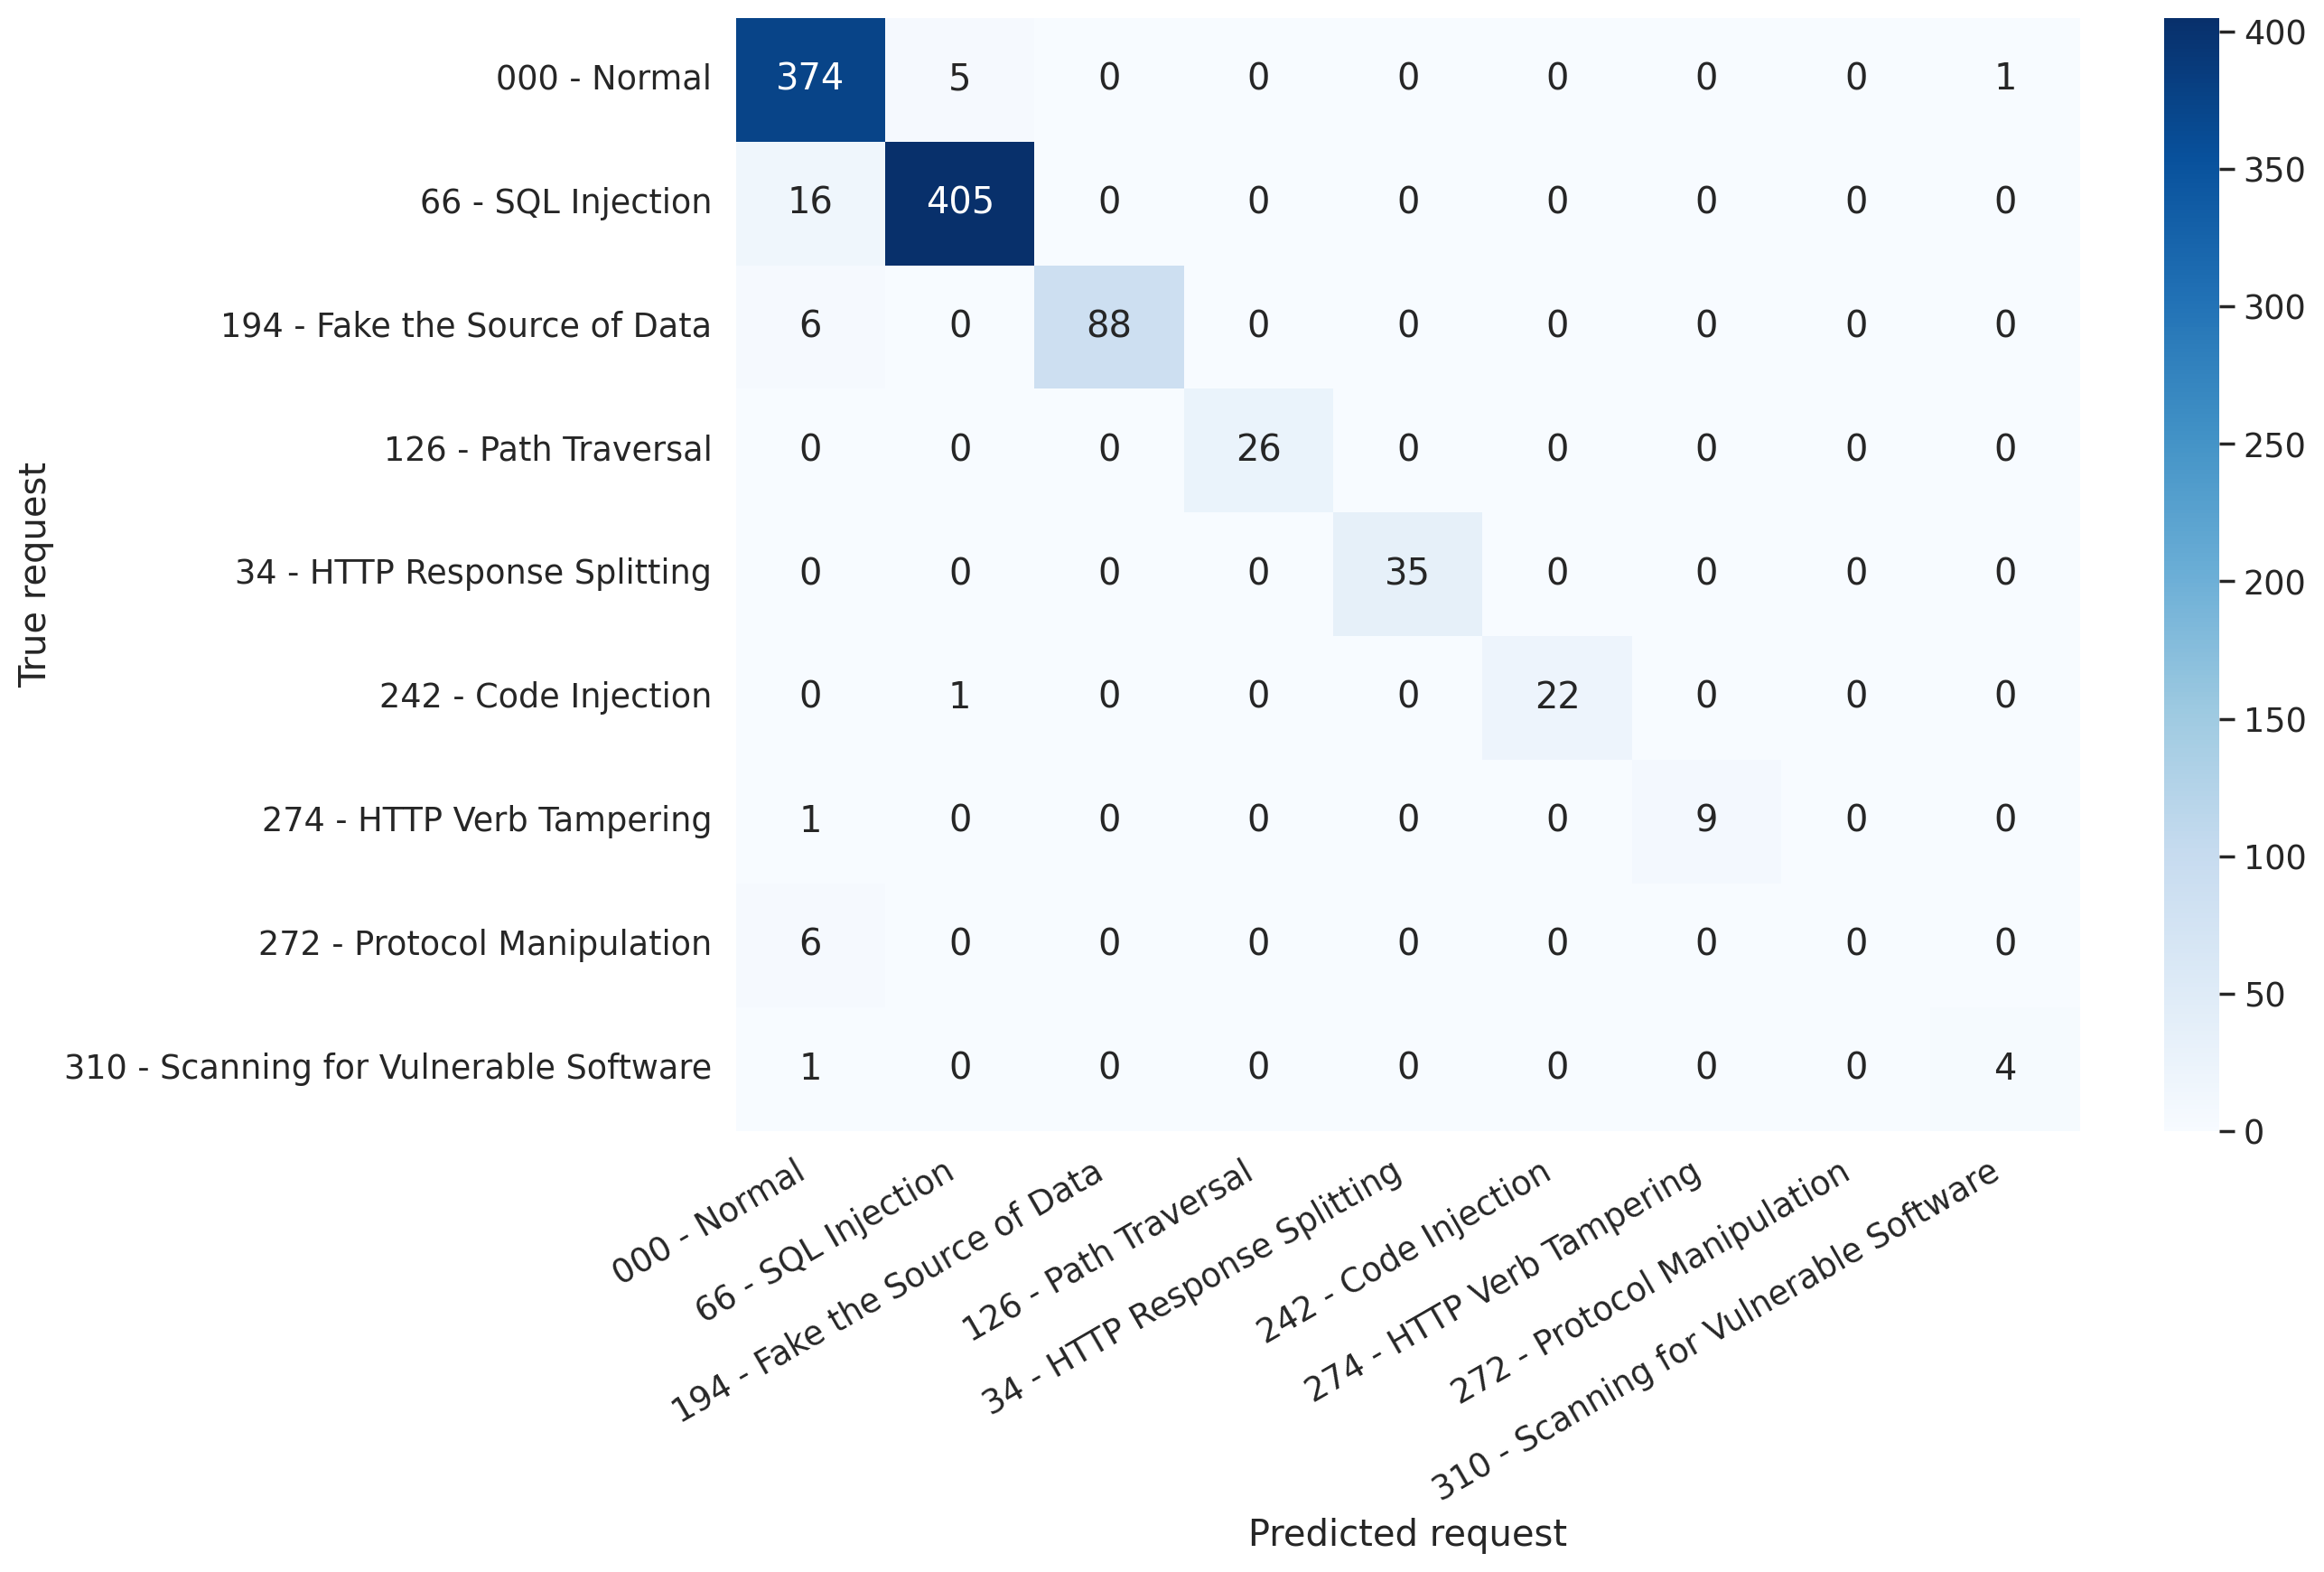

In [35]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True request')
    plt.xlabel('Predicted request');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That’s a good overview of the performance of our model.

## Predicting on raw text

In [36]:
review_text = "get blog index"

In [37]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

In [38]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'request  : {class_names[prediction]}')

Review text: get blog index
request  : 000 - Normal
